In [2]:
# Импорт необходимых библиотек
import torch
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import yaml
import cv2
from torchvision import transforms
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, ConfusionMatrixDisplay

In [3]:
# Загрузка модели
model = torch.load('resnet50_traffic_signs.pt')
model.eval()
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(DEVICE)

C:\Users\Spidrre\AppData\Local\Temp\ipykernel_23848\486807106.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('resnet50_traffic_signs.pt')
c:\Users\Sp

In [4]:
# Предобработка изображений
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

# Функция для тестирования модели
def test_model(model, test_images, test_labels):
    true_labels = []
    pred_labels = []
    
    for img_path, label_path in zip(test_images, test_labels):
        # Загрузка и предобработка изображения
        image = Image.open(img_path).convert('RGB')
        image = transform(image).unsqueeze(0).to(DEVICE)
        
        # Получение предсказания
        with torch.no_grad():
            outputs = model(image)
            # Get probabilities for all classes
            probabilities = torch.softmax(outputs.data, dim=1)
            # Get top predictions above threshold
            threshold = 0.32
            predictions = (probabilities > threshold).nonzero(as_tuple=True)[1]
            if len(predictions) > 0:
                # Add all detected objects
                pred_labels.extend(predictions.cpu().numpy().tolist())
            else:
                # If no confident predictions, take the max probability class
                _, predicted = torch.max(outputs.data, 1)
                pred_labels.append(predicted.item())
        
        # Загрузка ground truth метки
        with open(label_path, 'r') as f:
            gt_labels = [int(line.split()[0]) for line in f.readlines()]
            true_labels.extend(gt_labels)
    
    return true_labels, pred_labels

In [5]:
# Загрузка тестового набора данных
BASE_DIR = os.getcwd()
test_dataset_path = BASE_DIR + '/road-signs-2/test'
test_images = [f'{test_dataset_path}/images/{img}' for img in os.listdir(test_dataset_path+'/images')]
test_labels = [f'{test_dataset_path}/labels/{txt}' for txt in os.listdir(test_dataset_path+'/labels')]

In [6]:
# Получение результатов и метрик
true_labels, pred_labels = test_model(model, test_images, test_labels)

Precision: 0.8751
Recall: 0.8426
F1 Score: 0.8557
Accuracy: 0.8426


c:\Users\Spidrre\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


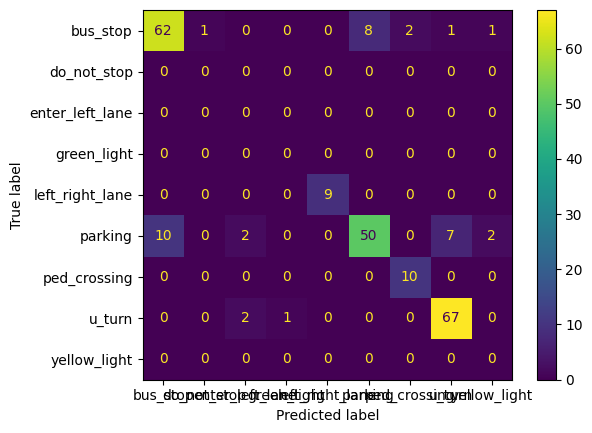

In [7]:
# Вычисление метрик
conf_matrix = confusion_matrix(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels, average='weighted')
recall = recall_score(true_labels, pred_labels, average='weighted')
f1 = f1_score(true_labels, pred_labels, average='weighted')
accuracy = accuracy_score(true_labels, pred_labels)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')

# Визуализация матрицы ошибок
yaml_path = BASE_DIR + '/road-signs-2/data.yaml'
with open(yaml_path, 'r') as f:
    data = yaml.safe_load(f)
    class_mapping = {i: name for i, name in enumerate(data['names'])}

labels_list = [value for key, value in class_mapping.items() if key in pred_labels]
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                             display_labels=labels_list)
disp.plot()
plt.show()

In [8]:
# Проходим по каждому изображению
for img_path in test_images:
    # Загружаем изображение
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Преобразуем изображение в тензор
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    img_tensor = transform(img).unsqueeze(0)
    
    # Получаем предсказания модели
    with torch.no_grad():
        outputs = model(img_tensor.cuda())
        probabilities = torch.softmax(outputs.data, dim=1)
        threshold = 0.32
        predictions = (probabilities > threshold).nonzero(as_tuple=True)[1]
        _, predicted = torch.max(outputs.data, 1)
        confidence = torch.nn.functional.softmax(outputs, dim=1)[0]
        class_id = predicted.item()
        conf = confidence[class_id].item()
    
    # ResNet классифицирует целое изображение
    height, width = img.shape[:2]
    x1, y1 = 0, 0
    x2, y2 = width, height
    
    # Получаем название класса
    class_name = class_mapping[class_id]
    
    # Рисуем прямоугольник
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    
    # Добавляем подпись с названием класса и уверенностью
    label = f'{class_name}: {conf:.2f}'
    cv2.putText(img, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    
    # Конвертируем обратно для отображения
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    
    # Показываем изображение
    cv2.imshow('Classification Result', img)
    
    # Ждем нажатия клавиши (q для выхода)
    if cv2.waitKey(0) & 0xFF == ord('q'):
        break

cv2.destroyAllWindows()